### Imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from typing import Iterable, Union
from toggle import hide_toggle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from get_data import get_training, get_test
from learning import fit, evaluate, plot_history
from plots import plot_features, plot_compare_features


from numpy.random import seed
seed(9849)
from tensorflow import set_random_seed
set_random_seed(6432)

hide_toggle()

In [2]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel1:Iterable, kernel2:Iterable, conv_filt: int, dense_filt: int,
                 optimizer = 'adam', loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(conv_filt, kernel_size = kernel1, padding = "same", input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel2))
    model.add(Dropout(0.5))
    model.add(Dense(dense_filt, activation='relu')) #kolejne relu
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    return model

# Loading data

In [3]:
# dire = "./npy_data/"
dire = "./npy_data2/"
# dire = "./npy_data3/"
# dire = "./npy_data_mix/"

class_no8 = np.load(dire+'class_no8.npy')
data_no8 = np.load(dire+'data_no8.npy')


class_no13 = np.load(dire+'class_no13.npy')
data_no13 = np.load(dire+'data_no13.npy')

class_no18 = np.load(dire+'class_no18.npy')
data_no18 = np.load(dire+'data_no18.npy')

class_no23 = np.load(dire+'class_no23.npy')
data_no23 = np.load(dire+'data_no23.npy')

class_no28 = np.load(dire+'class_no28.npy')
data_no28 = np.load(dire+'data_no28.npy')

class_no33 = np.load(dire+'class_no33.npy')
data_no33 = np.load(dire+'data_no33.npy')


hide_toggle()

## Picture options - time x freq bands or time x channels

In [4]:
freq_bands = 'ijkl->jlik' #better
channels = 'ijkl->jlki'
option = freq_bands

## Prepared combinations

In [5]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [6]:
batch_size = 200
no_epochs = 30
verbosity = 1
loss_fun = 'binary_crossentropy'

## Datasets

In [7]:
combination = 1

'''Train'''
X_train, y_train = get_training(X, y, combinations_train[combination], option)

'''Test'''
X_test, y_test = get_test(X, y, combinations_test[combination], option)

'''Validation'''
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

'''Cutting edges'''
X_train = X_train[:,5:71,:,:]
X_test = X_test[:,5:71,:,:]
X_validation = X_validation[:,5:71,:,:]


sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


In [8]:
print(f' Average count of trials (per participant): {(X_validation.shape[0] + X_test.shape[0] + X_train.shape[0] )/ 33} ; Total count of trials: {X_validation.shape[0] + X_test.shape[0] + X_train.shape[0]}')

 Average count of trials (per participant): 906.3939393939394 ; Total count of trials: 29911


In [9]:
X_validation.shape

(7317, 66, 5, 19)

In [10]:
[0,1,2,3][1:2]

[1]

In [11]:
class0 = np.count_nonzero(y_train[:,0])+np.count_nonzero(y_test[:,0])+np.count_nonzero(y_validation[:,0])
class1 = np.count_nonzero(y_train[:,1])+np.count_nonzero(y_test[:,1])+np.count_nonzero(y_validation[:,1])

In [12]:
print(class0)
print(class1)
print(class1+class0)

15056
14855
29911


## Learning

In [12]:
"Creating model"
model = create_model(sample_shape, 2, (11,1), (11,1), 8, 16, optimizer='adam')
print(model.summary())
"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 5, 8)          1680      
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 5, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 5, 8)           0         
_________________________________________________________________
dense (Dense)                (None, 6, 5, 16)          144       
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 480)               0         
_________________________________________

KeyboardInterrupt: 

## Evaluating

Test loss: 0.6810451362145082 / Test accuracy: 0.5681290030479431


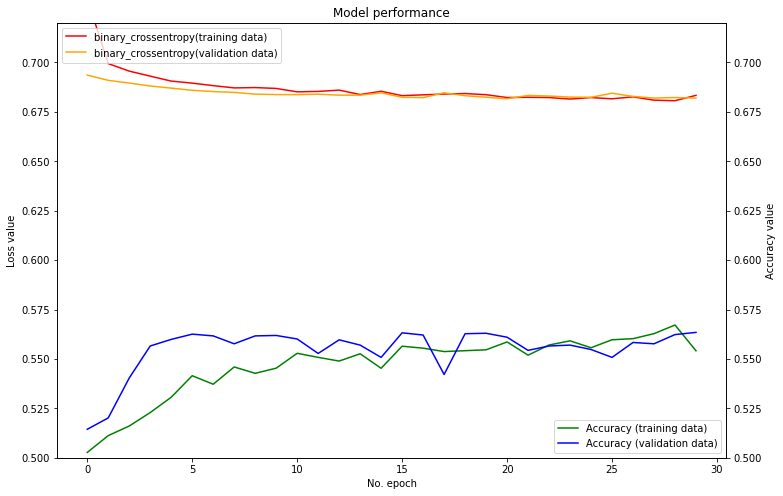

In [14]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

# Filters visualization

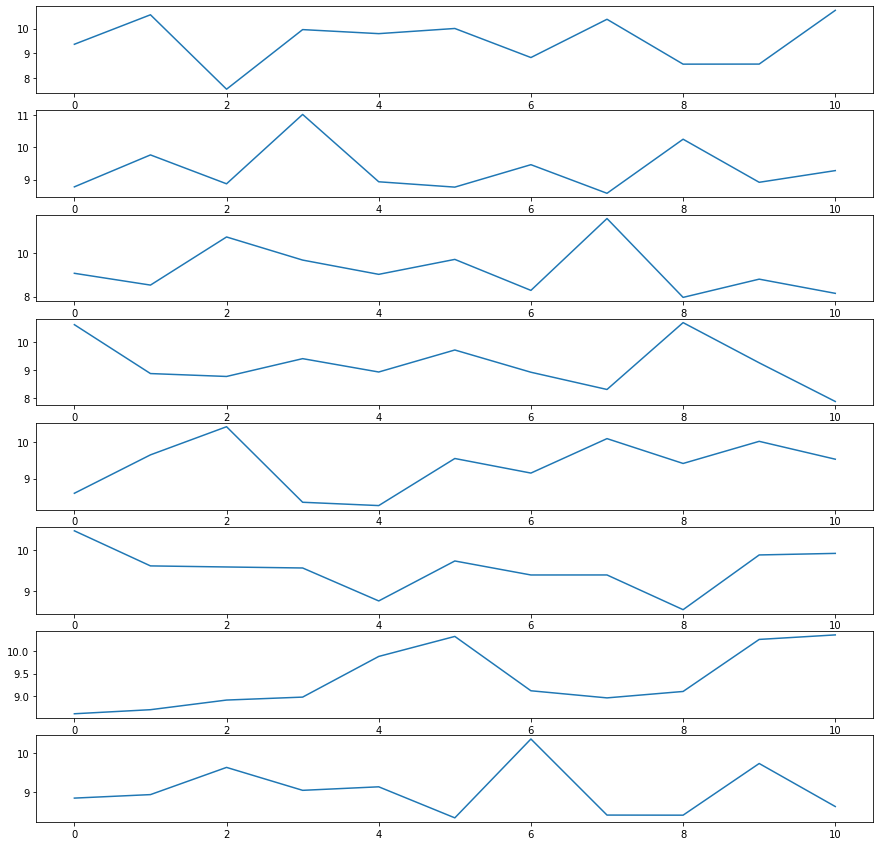

In [15]:
from matplotlib import pyplot
from scipy.signal import freqz

filters, biases = fitted_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 8, 1
pyplot.figure(figsize = (15,15))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    H = np.zeros(11)
    ax = pyplot.subplot(n_filters,1, i+1)
#     ax.set_xticks([])
#     ax.set_yticks([])
    for j in range(19):
        # specify subplot and turn of axis
#         ax = pyplot.subplot(n_filters, 19, ix)
#         ax.set_xticks([])
#         ax.set_yticks([])
        # plot filter channel in grayscale
        w, h = freqz(f[:, 0, j], worN = 6)
#         pyplot.imshow(f[:, :, j], cmap='gray') # ten sam limit?
#         pyplot.plot(abs(h))
        H = H + f[:, 0, j]
        ix += 1
    pyplot.plot(H)
# show the figure
pyplot.show()

# Feature map visualization

In [15]:
from matplotlib import pyplot
from scipy.signal import freqz
filters = 8
outputs = [fitted_model.layers[0].output]
model = Model(inputs=fitted_model.inputs, outputs=outputs)

NameError: name 'fitted_model' is not defined

### Feature map for one example

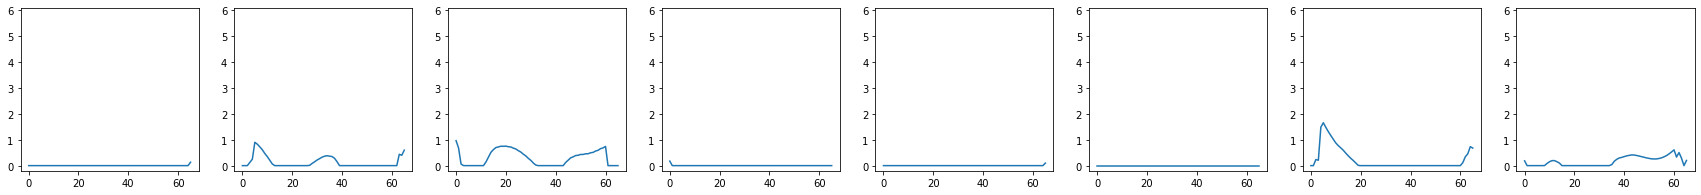

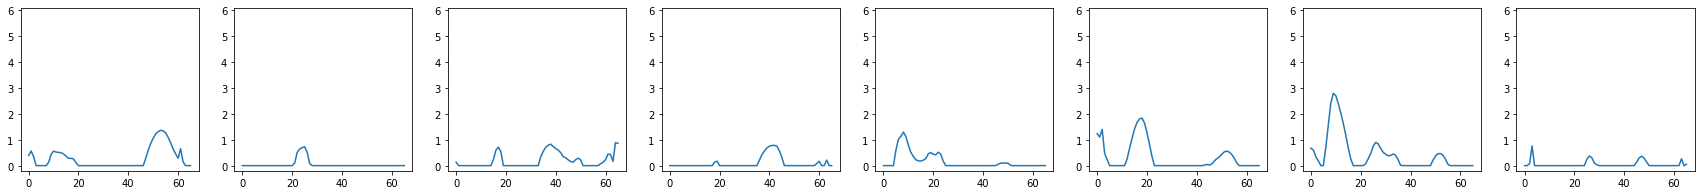

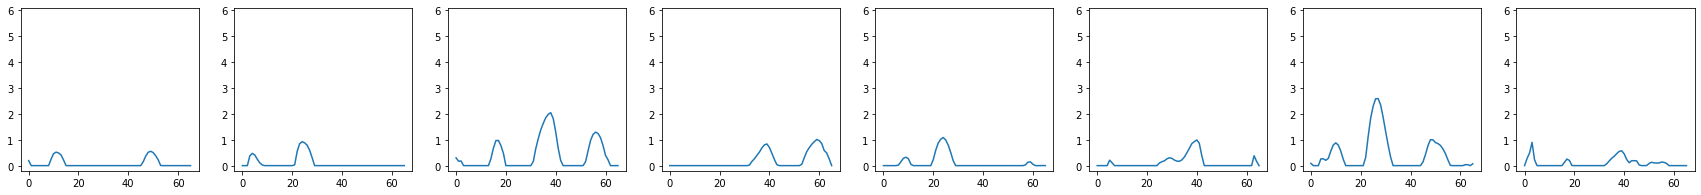

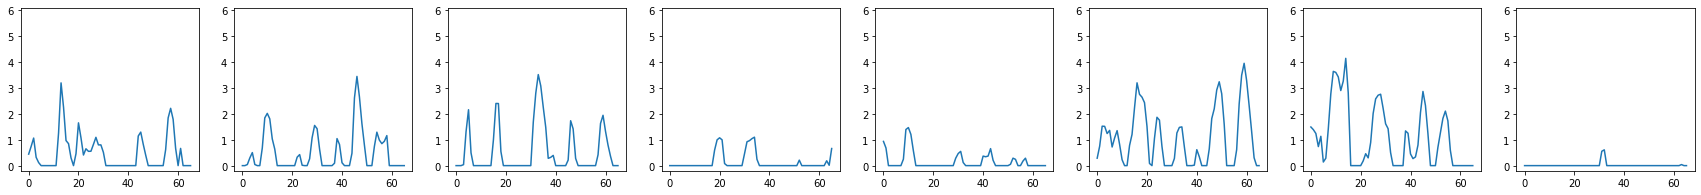

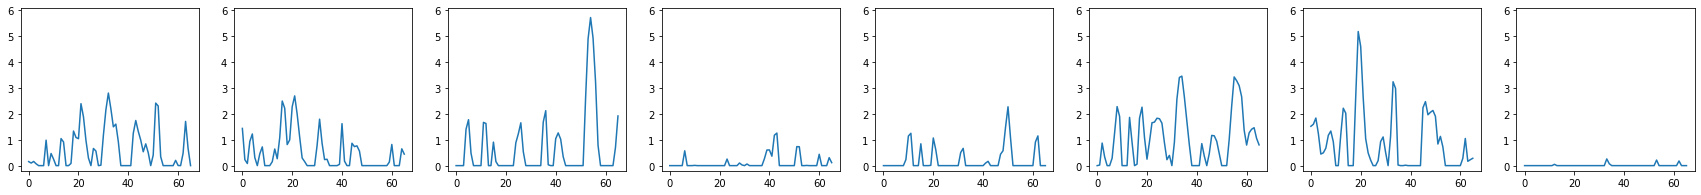

In [17]:
feature_maps = model.predict(np.expand_dims(X_validation[2],axis=0))

for i in range(5):
    pyplot.figure(figsize = (30,3))
    for x in range(filters):
        ax = pyplot.subplot(1, 8, x+1)
        pyplot.ylim(-0.2,6.1)
        pyplot.plot(feature_maps[0, :, i, x])
#         ix += 1
    pyplot.show()#Podpisać osie - pasma, czas itp

In [18]:
feature_maps.shape

(1, 66, 5, 8)

### Selecting model from directory

In [14]:
dire = "./models/"
model_name = "modelFINAL_data2.2"
fitted_model = load_model(dire+model_name)
outputs = [fitted_model.layers[0].output]
filters = 8
model = Model(inputs=fitted_model.inputs, outputs=outputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Mean maps

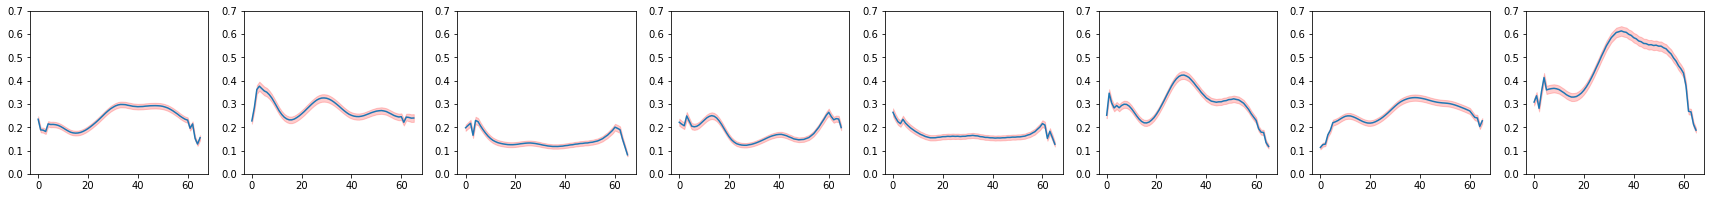

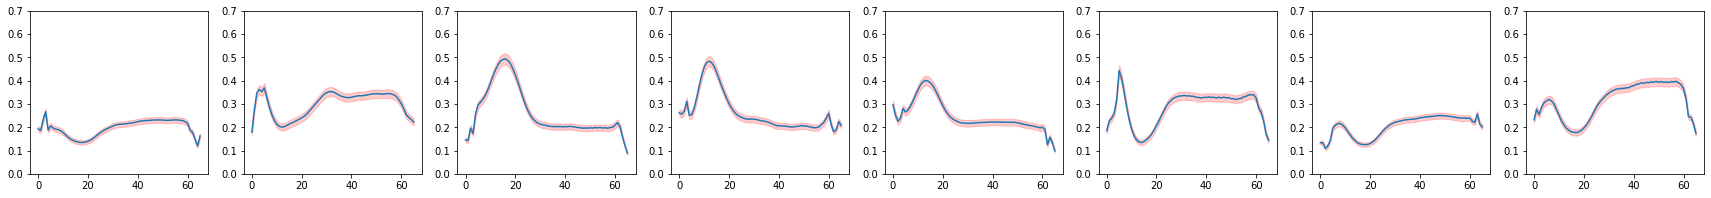

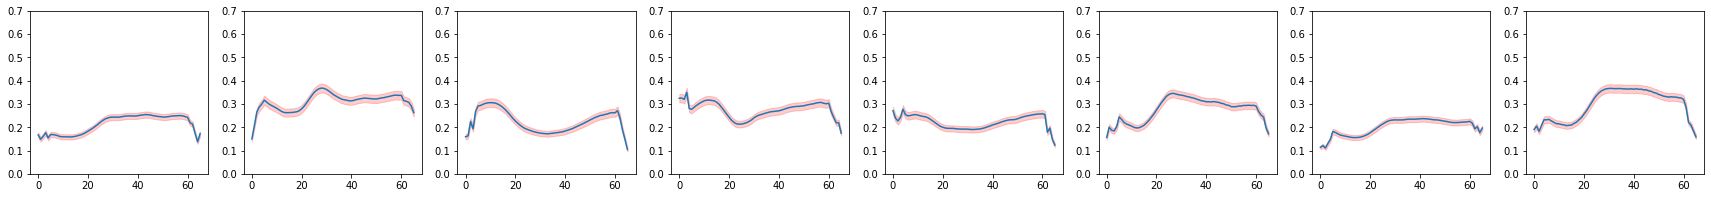

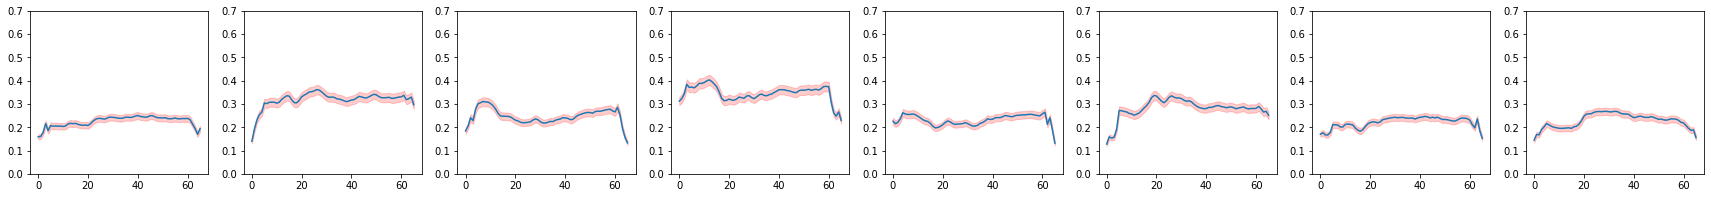

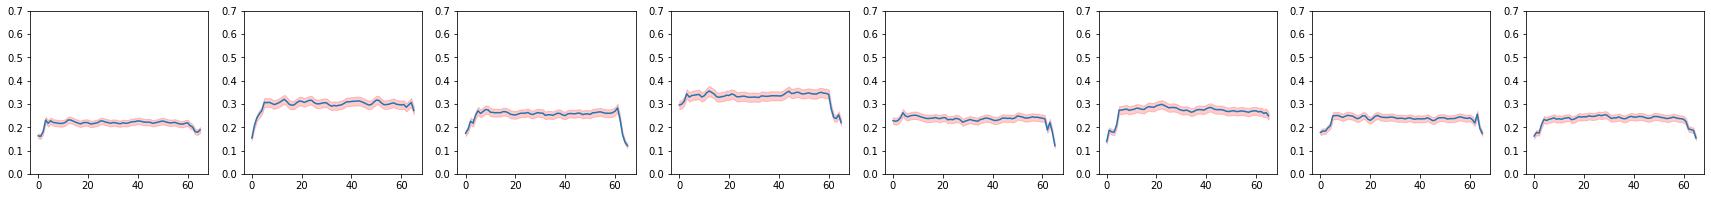

In [15]:
feature_maps = model.predict(X_validation)
plot_features(feature_maps, filters, (0,0.7))

In [106]:




def plot_compare_features(features1: Iterable, features2: Iterable, filt: int, ylim: Iterable[float]):
    feature_maps1 = np.mean(features1, axis=0)
    feature_std1 = 3*np.std(features1, axis=0)/np.sqrt(features1.shape[0])
    feature_maps2 = np.mean(features2, axis=0)
    feature_std2 = 3*np.std(features2, axis=0)/np.sqrt(features2.shape[0])
    fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(18, 12))
    cols = [f'Filter {col}' for col in range(1, 9)]
    rows = ['δ  ', 'θ  ', 'α  ', 'β  ', 'γ  ']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=17)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, fontsize=20)
    
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=17)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=0, fontsize=20)
    
    
    for i in range(5):
        
        for x in range(filt):
#             ax = plt.subplot(5, 8, sub_i+1)

            curv11 = feature_maps1[:, i, x] + feature_std1[:, i, x]      
            curv21 = feature_maps1[:, i, x] - feature_std1[:, i, x]
            curv12 = feature_maps2[:, i, x] + feature_std2[:, i, x]      
            curv22 = feature_maps2[:, i, x] - feature_std2[:, i, x]
            axes[i,x].fill_between(np.linspace(-8/64,58/64, 66)*1000, curv11, curv21, alpha = 0.3, color = 'r')
            axes[i,x].fill_between(np.linspace(-8/64,58/64, 66)*1000, curv12, curv22, alpha = 0.3, color = 'black')
            axes[i,x].plot(np.linspace(-8/64,58/64, 66)*1000, feature_maps1[:, i, x], color = 'r')
            axes[i,x].plot(np.linspace(-8/64,58/64, 66)*1000, feature_maps2[:, i, x], color = 'black')
            axes[i,x].axvline(0)
            axes[i,x].axvspan(0.25*1000, 0.75*1000, alpha=0.25, color='yellow')
#             plt.axvline(0.25, color="red")
#             plt.axvline(0.75, color="red")
            axes[i,x].set_ylim(ylim[0], ylim[1])
#             axes[i,x].subplots_adjust(wspace=0.1, hspace=0.1)
            axes[i,x].tick_params(axis='y',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False,# ticks along the top edge are off
                            left=False,
                            labelleft=False,
                            labelbottom=False) # labels along the bottom edge are off

    plt.show()

## Dobrze sklasyfikowane

In [107]:
features_maps = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
features_good = features_maps[ind_good]

## Źle sklasyfikowane

In [108]:
features_maps = model.predict(X_validation)
ind_bad = np.where(fitted_model.predict_classes(X_validation) != class_no8)[0]
features_bad = features_maps[ind_bad]

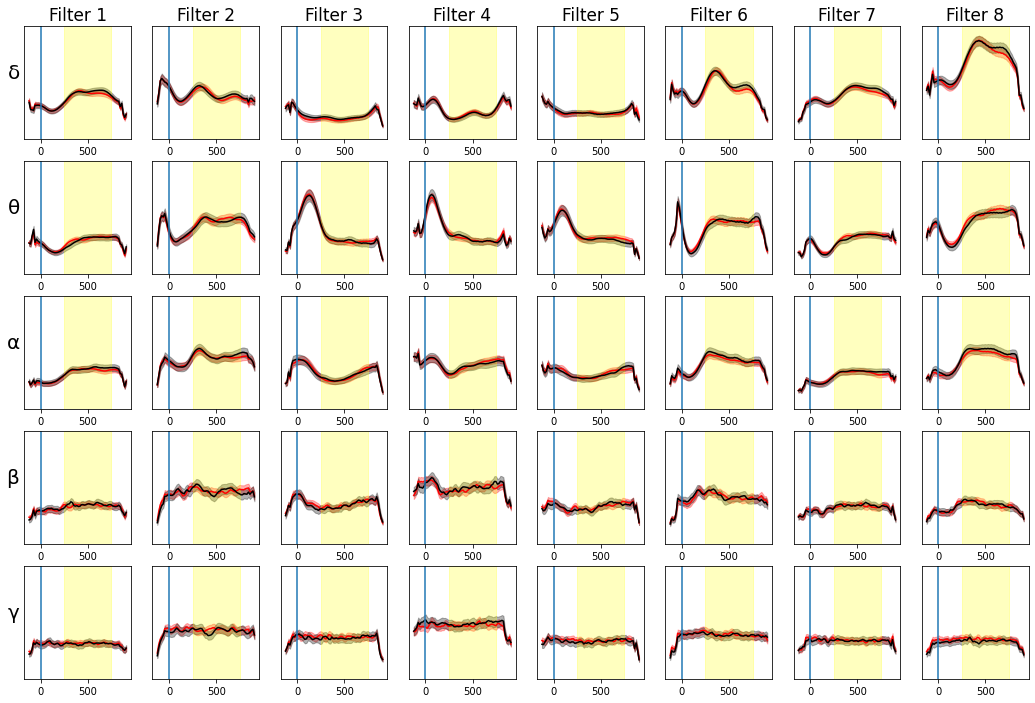

In [109]:
plot_compare_features(features_good, features_bad, filters, (0,0.7))

## Wśród poprawnie zaklasyfikowancyh kategoria 0

In [110]:
features = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
ind_good1 = np.where(class_no8 == 1)[0]
ind_good1 = np.unique(np.concatenate((ind_good, ind_good1)))
ind_good2 = np.where(class_no8 == 0)[0]
ind_good2 = np.unique(np.concatenate((ind_good, ind_good2)))

features_good = features[ind_good]
features_good1 = features[ind_good1]
features_good2 = features[ind_good2]

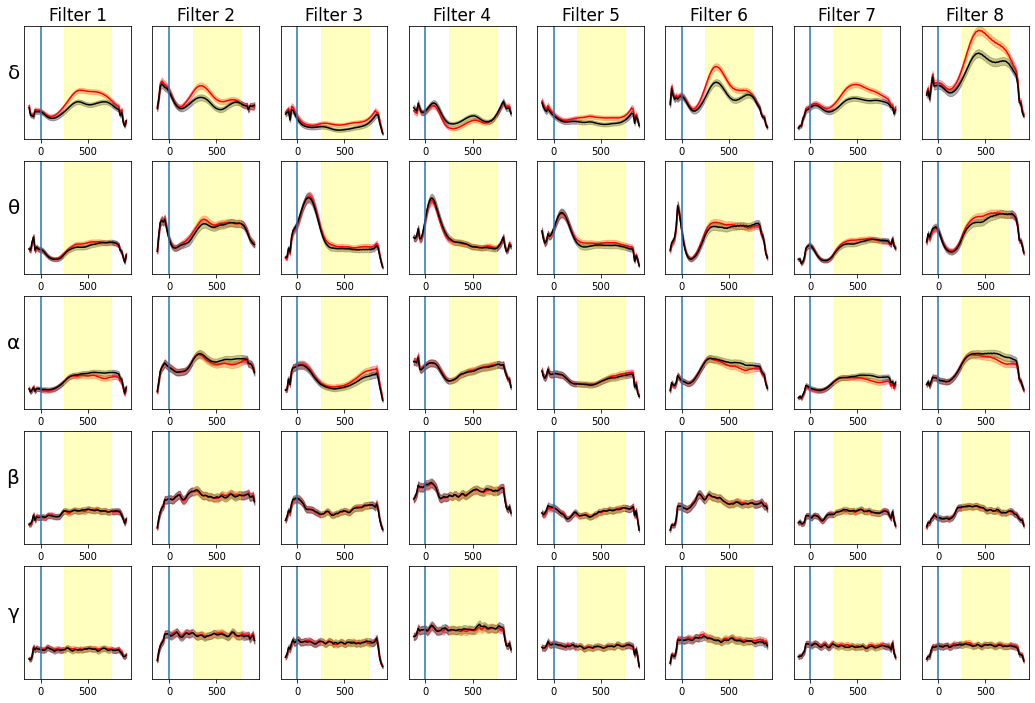

In [111]:
filters = 8

plot_compare_features(features_good1, features_good2, filters, ylim = (0.05,0.7))

# Zostać przy feature mapsach, filtrów nie brać do obrazowania - za mało widać

## Collecting votes

In [13]:
suf_mod = "modelFINAL_data2."

In [26]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [27]:
X_validation = X_validation[:,5:71,:,:]
X_validation.shape

(7317, 66, 5, 19)

Test loss: 0.6843445749007174 / Test accuracy: 0.553778886795044


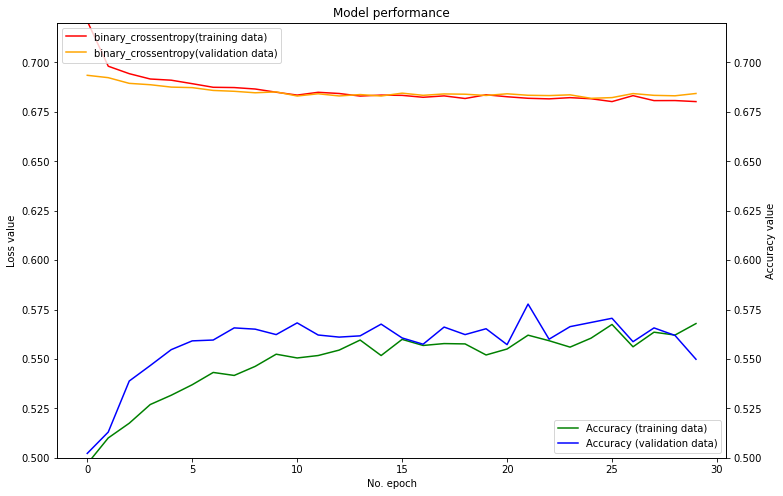

0
Test loss: 0.6836019996021621 / Test accuracy: 0.5581522583961487


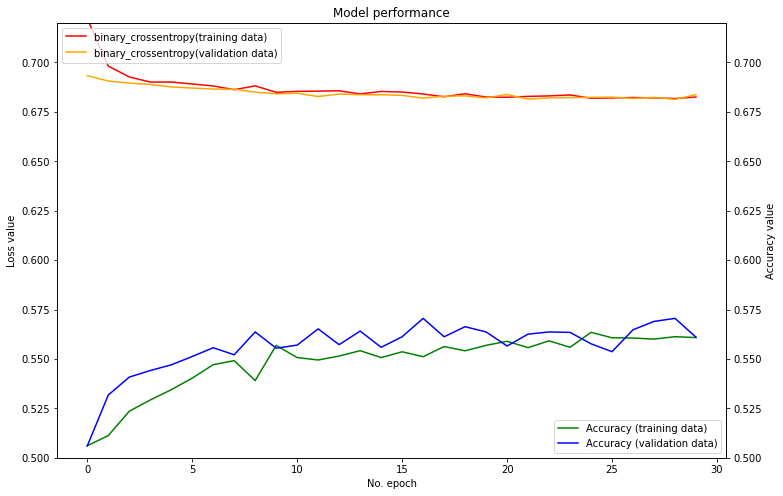

1
Test loss: 0.677372524960536 / Test accuracy: 0.583709180355072


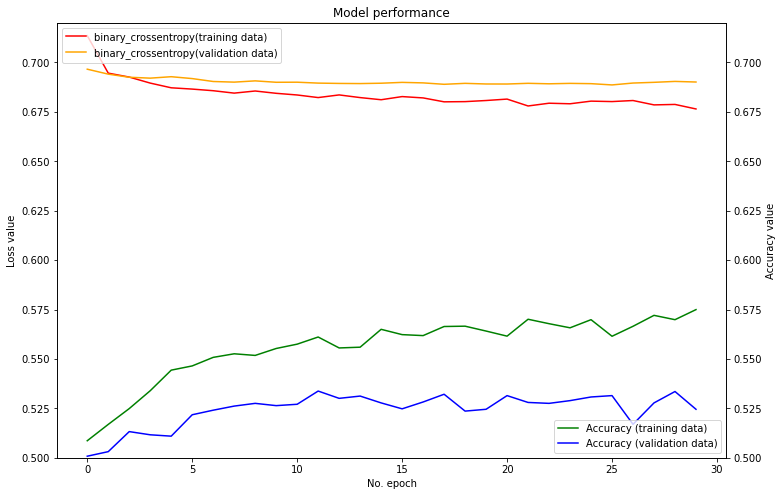

2
Test loss: 0.682629011474673 / Test accuracy: 0.5719557404518127


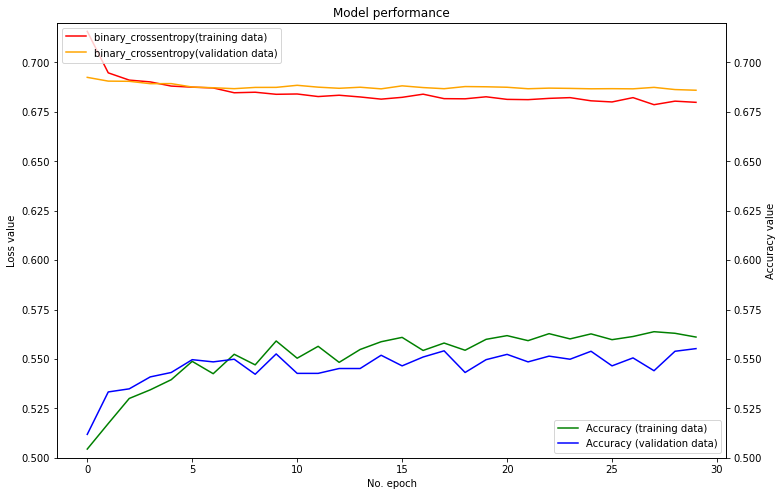

3
Test loss: 0.6871402880052929 / Test accuracy: 0.5582889318466187


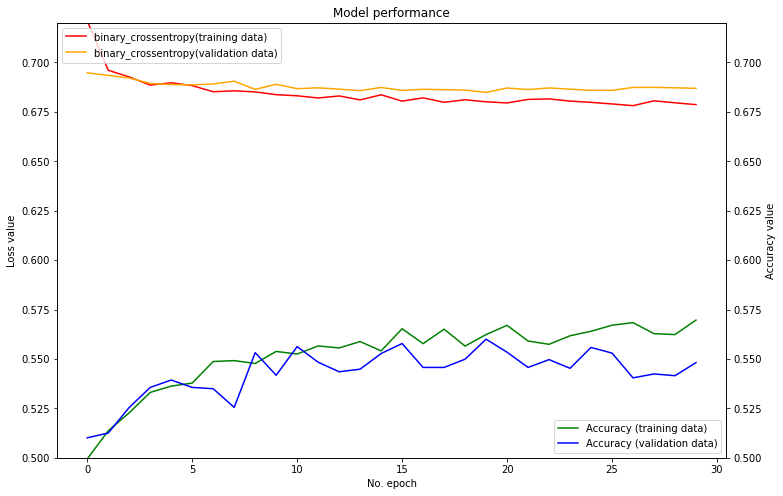

4
0.5807024736914036


In [28]:
batch_size = 200
no_epochs = 30

trials = y_validation.shape[0]
pred = np.zeros((5,trials))
test_loss = []

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], option)
    X_test, y_test = get_test(X, y, combinations_test[i], option)
    X_train = X_train[:,5:71,:,:]
    X_test = X_test[:,5:71,:,:]
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    #sample_shape, 2, (11,1), (11,1), 8, 16, optimizer='adam'
    model = create_model(sample_shape, 2, (11,1),(11,1), 8, 16, optimizer='adam')
    
    fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs, verbosity = 0)
    fitted_model.save('./models/'+suf_mod+str(i))
    "Getting validation and loss score"
    score = evaluate(fitted_model, X_validation, y_validation)
    test_loss.append(score)
    "Plotting history"
    plot_history(hist, loss_fun)
    "Saving predictions"
    pred[i] = fitted_model.predict_classes(X_validation)
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

# OKLUZJA

In [29]:
replacement = np.mean(X_validation, axis = 0)
acc_score = np.empty((5,5,19))

for i in range(5):
    model = load_model('./models/'+suf_mod+str(i))
    score = evaluate(model, X_validation, y_validation)
    acc = score[1]
    for band in range(5):
        for ch in range(19):
            X_temp = X_validation.copy()
            X_temp[:,:,band,ch] = replacement[:,band,ch]
#             X_temp[:,:,band,ch] = 0
            score = evaluate(model, X_temp, y_validation, verbose = 0)
            acc_score[i,band,ch] = acc-score[1]
        print(f'FINISHED BAND: {band}')
    print('FINISHED MODEL ' + str(i))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Test loss: 0.6843445749007174 / Test accuracy: 0.553778886795044
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 0
Test loss: 0.6836019996021621 / Test accuracy: 0.5581522583961487
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 1
Test loss: 0.677372524960536 / Test accuracy: 0.583709180355072
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 2
Test loss: 0.682629011474673 / Test accuracy: 0.5719557404518127
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 3
Test loss: 0.6871402880052929 / Test accuracy: 0.5582889318466187
FINISHED BAND: 0
FINISHED BAND

In [14]:
# np.save('predictions.npy',prediction)
np.save(f'acc_score_{suf_mod[:-1]}.npy',acc_score)

NameError: name 'acc_score' is not defined

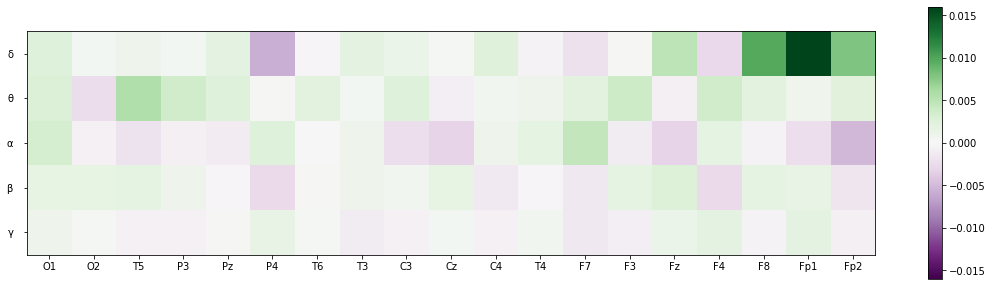

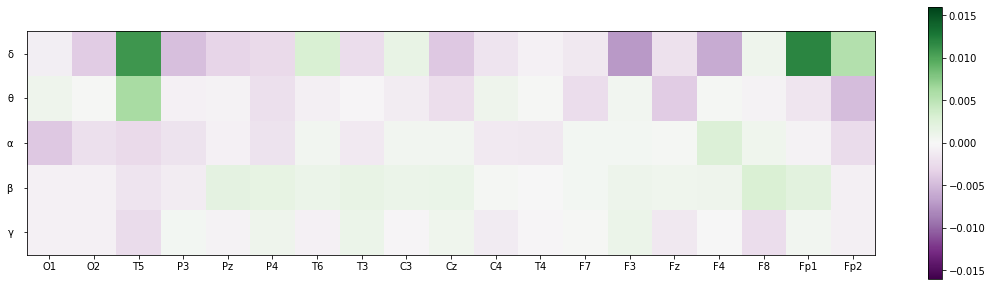

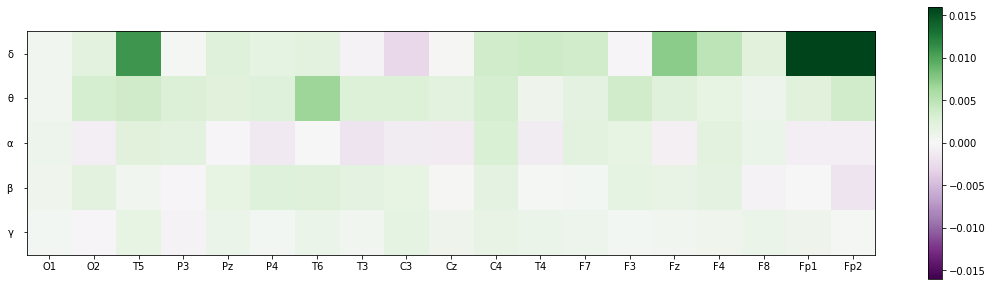

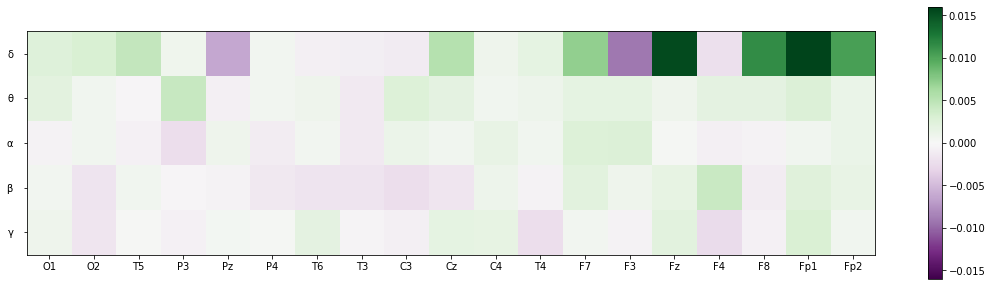

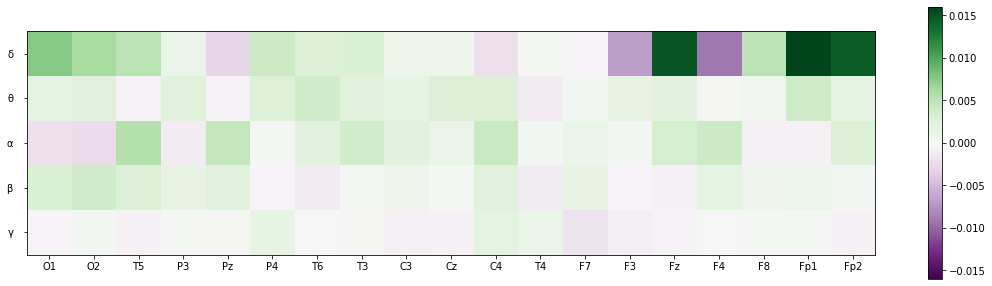

In [14]:
acc_score = np.load(f'acc_score_{suf_mod[:-1]}.npy')
# spróbować wyplotować topoplot główki dla elektrod i poszczególnych pasm
chan = np.load('channels.npy')
for i in range(5):
    plt.figure(figsize = (19,5))
    
    plt.imshow(acc_score[i], cmap = 'PRGn')
    plt.clim(-0.016,0.016)
    plt.yticks(np.arange(5), labels=['δ  ', 'θ  ', 'α  ', 'β  ', 'γ  '])
    plt.xticks(np.arange(len(chan)), labels=chan)
    plt.colorbar()
    plt.show()

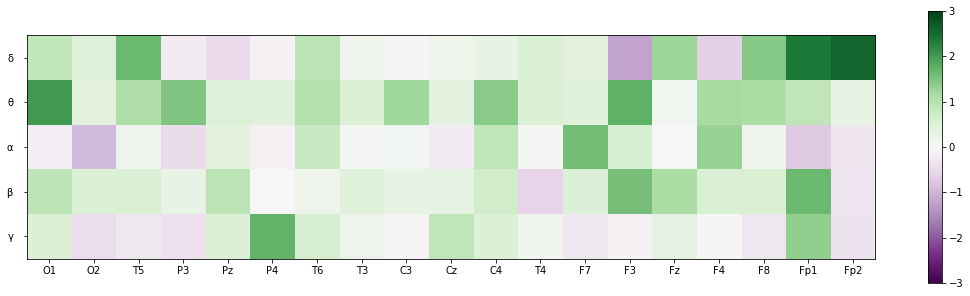

In [15]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0)/np.std(acc_score, axis=0), cmap = 'PRGn')
plt.clim(-3,3)
plt.xticks(np.arange(len(chan)), labels=chan)
plt.yticks(np.arange(5), labels=['δ  ', 'θ  ', 'α  ', 'β  ', 'γ  '])
plt.colorbar()
plt.show()
#podpisać nazwami kanałów

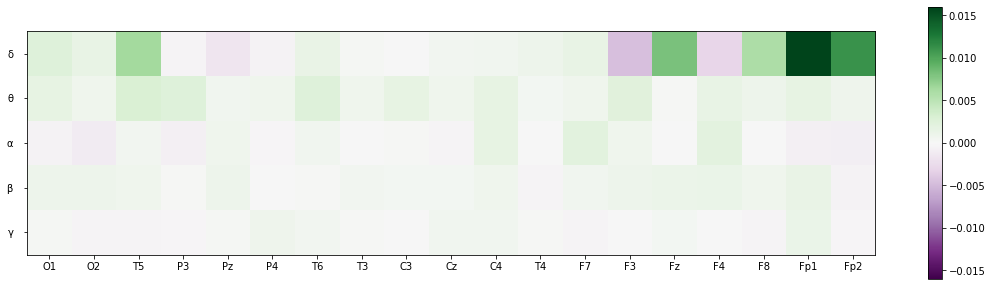

In [16]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0), cmap = 'PRGn')
plt.clim(-0.016,0.016)
plt.xticks(np.arange(len(chan)), labels=chan)
plt.yticks(np.arange(5), labels=['δ  ', 'θ  ', 'α  ', 'β  ', 'γ  '])
plt.colorbar()
plt.show()
#podpisać nazwami kanałów

In [ ]:
# hipoteza - sieć nauczyła się sygnałów pochądzącyych od artefaktów ocznych

In [18]:
fs = 64
t1 = 5
t2 = 71
t1p = 0
t2p = 77
T1 = -0.2
T2 = 1
0.2 * 64 +64

76.8

In [20]:
0.2*64

12.8

In [24]:
np.linspace(-8/64,58/64, 66)

array([-0.125     , -0.10913462, -0.09326923, -0.07740385, -0.06153846,
       -0.04567308, -0.02980769, -0.01394231,  0.00192308,  0.01778846,
        0.03365385,  0.04951923,  0.06538462,  0.08125   ,  0.09711538,
        0.11298077,  0.12884615,  0.14471154,  0.16057692,  0.17644231,
        0.19230769,  0.20817308,  0.22403846,  0.23990385,  0.25576923,
        0.27163462,  0.2875    ,  0.30336538,  0.31923077,  0.33509615,
        0.35096154,  0.36682692,  0.38269231,  0.39855769,  0.41442308,
        0.43028846,  0.44615385,  0.46201923,  0.47788462,  0.49375   ,
        0.50961538,  0.52548077,  0.54134615,  0.55721154,  0.57307692,
        0.58894231,  0.60480769,  0.62067308,  0.63653846,  0.65240385,
        0.66826923,  0.68413462,  0.7       ,  0.71586538,  0.73173077,
        0.74759615,  0.76346154,  0.77932692,  0.79519231,  0.81105769,
        0.82692308,  0.84278846,  0.85865385,  0.87451923,  0.89038462,
        0.90625   ])